In [1]:
from sys import path
path.append('../')
import w12_estimation as est
import w12_LinearModels as lm
import w12_SampleSelection_ante as ssm

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

# Introduction

In this dataset, you will use a part of the dataset from
Conley and Decarolis (2016). The data contains bids for public procurement
auctions for roadwork in Italy. In 2008, the Turin Court of Justice
ruled that in 276 auctions for roadwork held between 2000 and 2003, the
auctions had been rigged by 8 cartels made up of 95 firms. It turns out
that the auction format, called the Average Bid Auction (ABA), is
particularly susceptible to collusion between bidders. However, for a
cartel to be successful at one particular auction, it is essential that
many cartel participants be present at that auction. When enough of the
cartel is present at the auction, they are able to strategically
manipulate the average bid.

The implication is that the bids made by a given firm depends on the
identity of other firms showing up at the auction. This contradicts a
perfectly competitive setting, in which firms should not condition their
bids on the specific identities of their opponents. Thus, one can
test for (lack of) perfect competition by checking whether the bid posted by a firm
depends on how closely connected the firm is to other firms in that
auction (see Conley and Decarolis (2016) for details on how to quantify connectivity). 
If firms were randomly distributed across auctions, then there
should be no systematic link between these quantities.
In that case, we could just
regress the bid on how closely connected the firm is to other
firms in the auction, controlling for proxies for the "size" of the firm
(labor, capital, etc.).

The issue is that firms are *not* randomly allocated to auctions. Instead,
firms are more likely to participate in auctions involving sites that are close to their
headquarters. Moreover, the distance to the site of the roadwork project being
auctioned may act as our **exclusion restriction** under the following
assumptions:

1.  Firms prefer to win (hence, are more likely to bid on) projects close to home.

2.  Conditional on participating in an auction, distance does not matter for the
    *marginal* cost of conducting roadwork.

The figure below shows the distribution of
distances from all eligible firms to the sites, split by whether the
firm chose to participate or not. This clearly shows that distance
affects the likelihood of participation.

<img src="../smaller_pic.png" alt="Drawing" style="width: 500px;"/>

Part 2 may certainly be criticized. (Food for thought: Think about which types of projects
and firm behavior fit this description, and which types that do not.) Coming up
with credible exclusion restrictions is a delicate matter. Here we focus on
the mechanics of estimation with sample selection.


# Data

After deleting rows with missing observations, the data covers 891
auctions where a large number of firms considered whether or not to make
a bid. There are $N=91,845$ observations where a firm was eligible to
make a bid, and if it did, we observe the variable $y_{1i}=1$ (called
`participation` in the data). Otherwise, $y_{1i}=0$.

The submitted bid, which is only available for the 37,699 observations
where $y_{1i}=1$, is the variable `bid_discount`, which we denote
$y_{2i}$. It indicates the percentage discount relative to the
reservation price chosen by the auctioneer, which a firm is willing to
conduct the project for. The variable is missing (i.e. equal to `NaN`)
whenever $y_{1i}=0$ -- that is, when the given firm did not submit a bid
in the auction.

The exclusion restriction to be used is $z_{i}=$ `logmiles_fiwo`, which
is the log of (one plus) the miles between the address of the firm
(rather, the centroid of the zip code of the firm) and the site of the
project under procurement. The remaining variables are described below:

| **Variable** | **Description** |
| ---- | ---- |
| backlog_lagged  | a measure of the number of projects currently in progress at the firm. 	|
| logcapital | log of the total capital (accounting variable).	|
| labor | measure of employed labor.	|
| count_linktot_out  | A measure of closeness to other firms.	|
| auction_type | =0 if the auction is an Average Bid Auction,	|
|				|=1 for First Price Sealed Bid.	|
| participated  | whether the firm submitted a bid (yi1).	|
| logmiles_fiwo | distance from the firm to the location of the project under auction.	|
| firm_type_unlim_liab  | Firm is not limited liability.	|
| auction_id | ID variable for the auction.	|
| region | Dummy for the region in which the project is to take place. 	|
| year | Calendar year.	|

# The Heckman 2-step

Suppose our dataset consists of $N$ observations of
$\{x_{i},y_{2i}\}_{i=1}^{N}$, where $y_{2i}$ indicates
participation ("selection") and $x_{i}\in\mathbb{R}^{K}$. For auction
participants $\{i|y_{2i}=1\}$, we furthermore see the bid
$y_{1i}$, a real number. 

We adopt the Heckman model: 

$$
\begin{aligned}
y_{1i} & = \mathbf{x}_{1i}\boldsymbol{\beta}_o+u_{i},\\
y_{2i} & = \mathbf{1}\{\mathbf{x}_{i}\boldsymbol{\delta}_o+v_{i}>0\},\\
\left(u_i,v_i\right) & \text{ and } \mathbf{x}_i \text{ independent},\\
v_i&\sim\mathrm{N}\left(0,1\right),\\
\mathrm{E}[u_i \mid v_{i}=v] & = \gamma_{o} v.
\end{aligned}
$$

We prepare the data below.

In [7]:
# Since we are doing some more advanced data choices, we start by using pandas.
# This makes the whole process easier.
data = pd.read_csv('w12_conley_decariolis.csv', sep=',')
data['t'] = data['year'] - min(data['year'])



In [8]:
# Create labels for variables
y2lbl = 'participated'
exclusion_restriction = 'logmiles_fiwo'
x2lbl = ['backlog_lagged',  'logcapital', 'count_linktot_in', 'labor', 'firm_type_unlim_liab', 't']
# ^-- all explanatory variables but the exclusion restriction

# We want to check for missing valuess and remove them, but only for variables that we are interested in.
# We therefore gather all the labels into one "check_missing" label.
check_missing = x2lbl.copy()
check_missing.append(y2lbl)
check_missing.append(exclusion_restriction)

In [9]:
# Keep only auctions that are of type "average bid", which is the 0 category.
data = data[data['auction_type'] == 0.0]

# Remove missing values only present in the variables denoted by check_missing labels.
data.dropna(inplace=True, subset=check_missing)

In [10]:
# Allocate data.
# y2 is whether a firm participated in the auction or not.
y2 = data[y2lbl].to_numpy().reshape(-1, 1)

# Exclusion restriction is distance from company to job.
z = data[exclusion_restriction].to_numpy().reshape(-1, 1)

x2 = data[x2lbl].to_numpy()
cnst = np.ones(y2.size).reshape(-1, 1)
x2 = np.hstack((x2, cnst))

# x (and y2) is to be used for the participation equation.
x = np.hstack((z, x2))

# y1 denotes the bid.
# We now keep in x1 only those who bid on the auction
y1 = data['bid_discount'][data['participated'] == 1].to_numpy().reshape(-1, 1)
x1 = x2[data['participated'] == 1]

# Add constant to labels
x2lbl.append('const')
# add exclusion restriction to labels
xlbl = x2lbl.copy()
xlbl.append(exclusion_restriction)

## Question 1:
Estimate the bid equation without controlling for selection into the sample. Gather the results in a table, and focus on the effect of `count_linktot_in` as a proxy for firm connectivity. Based on these preliminary results, does connectivity appear to matter?

In [27]:
# estimate bid equation by OLS
ols = lm.estimate(y1,x1)


In [29]:
lm.print_table((y2lbl,x2lbl), ols, ['beta', 'se', 't'], title='OLS estimation of bid equation')

OLS estimation of bid equation
Dependent variable: participated

                            beta           se           t
--------------------  ----------  -----------  ----------
backlog_lagged        -0.0483714  0.175607      -0.275452
logcapital            -0.139889   0.0211705     -6.60775
count_linktot_in       0.013238   0.00182241     7.26399
labor                  0.0040932  0.000855416    4.78504
firm_type_unlim_liab  -1.03893    0.117332      -8.85466
t                      0.66852    0.0424619     15.744
const                 12.7181     0.0725357    175.336
R² = 0.010
σ² = 27.444


*Your results should look like this:*

Results w/o accounting for selection.
Dependent variable: Bid discount

|                      |    Beta |       Se |   t-values |
|---------------------:|--------:|---------:|-----------:|
|       backlog_lagged | -0.0484 |   0.1756 |    -0.2755 |
|           logcapital | -0.1399 |   0.0212 |    -6.6077 |
|     count_linktot_in |  0.0132 |   0.0018 |     7.2640 |
|                labor |  0.0041 |   0.0009 |     4.7850 |
| firm_type_unlim_liab | -1.0389 |   0.1173 |    -8.8547 |
|                    t |  0.6685 |   0.0425 |    15.7440 |
|                const | 12.7181 |   0.0725 |   175.3357 |

R² = 0.010
σ² = 27.444

## Question 2: 
Replicate the histogram above, showing that there might be a selection bias. You do this by using the `Data` frame, and plot the histograms of `logmiles_fiwo` both for `participated == 0` and `participated == 1`. See if you are able to plot both histograms in the same plot, with a transparent overlap.

Text(0.5, 1.0, 'Histogram of log distance by participation status')

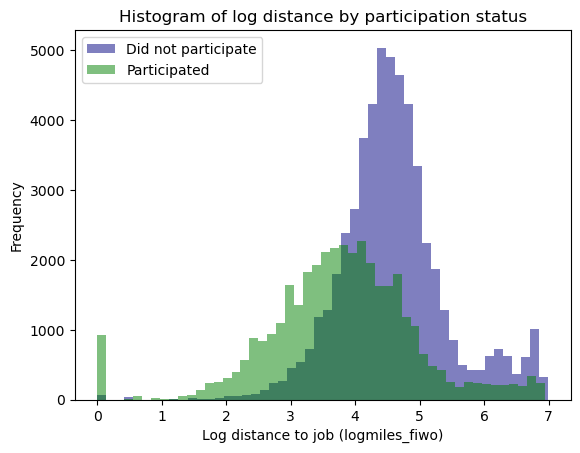

In [69]:
fig, ax = plt.subplots()
ax.hist(data.loc[data['participated'] == 0, 'logmiles_fiwo'], bins=50, alpha=0.5, color='navy')
ax.hist(data.loc[data['participated'] == 1, 'logmiles_fiwo'], bins=50, alpha=0.5, color='green')
ax.set_xlabel('Log distance to job (logmiles_fiwo)')
ax.set_ylabel('Frequency')
ax.legend(['Did not participate','Participated'])
ax.set_title('Histogram of log distance by participation status')


## Question 3
Conduct the "Heckit" procedure (Wooldridge's Procedure 19.1) using `logmiles_fiwo` as the exclusion restriction. 
Does `logmiles_fiwo` (still) seem relevant?
Is the coefficient on the inverse Mills ratio significant? How do you interpret this finding? 
Can you draw any conclusion on whether `count_linktot_in` seems to matter?

In [49]:
from scipy.stats import norm
beta_start = ssm.starting_values(y2, x)
probit_res = est.estimate(ssm.q, beta_start,y2,x)
pred = x @ probit_res['theta'] 
lambda_hat = norm.pdf(pred) / norm.cdf(pred)
x1

Optimization terminated successfully.
         Current function value: 0.513605
         Iterations: 34
         Function evaluations: 342
         Gradient evaluations: 38


c:\Users\annal\Desktop\AME\VScode_opgaver\AME_2025\Excercise classes\Class 12\w12_estimation.py:102: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(np.diag(cov))


array([[ 0.       ,  0.8501509,  5.       , ...,  0.       ,  1.       ,
         1.       ],
       [ 0.       ,  1.592088 , 13.       , ...,  0.       ,  1.       ,
         1.       ],
       [ 0.       ,  1.592088 ,  2.       , ...,  0.       ,  1.       ,
         1.       ],
       ...,
       [ 0.       ,  0.       , 28.       , ...,  1.       ,  2.       ,
         1.       ],
       [ 0.       ,  0.       , 21.       , ...,  1.       ,  0.       ,
         1.       ],
       [ 0.       ,  0.       , 13.       , ...,  1.       ,  1.       ,
         1.       ]], shape=(37699, 7))

In [56]:
# heckit two-step procedure
from scipy.stats import norm
def heckit_ts(y2, x, x1, y1):
    # step 1:  probit y2 on x and obtain biased estimates
    # a. starting values
    beta_start = ssm.starting_values(y2, x)
    # b. estimate probit
    probit_res = est.estimate(ssm.q, beta_start, y2, x)
    # c. compute inverse Mills ratio
    pred = x @ probit_res['theta'] 
    lambda_hat = norm.pdf(pred) / norm.cdf(pred)
    
    # step 2: OLS of y1 on x1 and lambda_hat
    # a. subset lambda_hat to only participated observations
    lambda_hat_participated = lambda_hat[y2.flatten() == 1]
    # b. stack x1 and lambda_hat_participated
    stack = np.hstack((x1, lambda_hat_participated.reshape(-1, 1)))
    # c. estimate OLS
    ols_res = lm.estimate(y1, stack)
    return probit_res, ols_res

In [57]:
# use heckit two-step procedure
probit_res, ols_res = heckit_ts(y2, x, x1, y1)

Optimization terminated successfully.
         Current function value: 0.513605
         Iterations: 34
         Function evaluations: 342
         Gradient evaluations: 38


In [ ]:
probit_res # forkerte standardfejl på ene eller anden måde

{'theta': array([-0.1242503 ,  0.05475666,  0.05201922,  0.06892792, -0.00090891,
         0.09932402,  0.01667513, -0.3488196 ]),
 'se': array([          nan,           nan,           nan,           nan,
                  nan, 8.5787776e+08,           nan,           nan]),
 't': array([           nan,            nan,            nan,            nan,
                   nan, 1.15778757e-10,            nan,            nan]),
 'cov': array([[-1.89253719e+19,  6.50694632e+17, -9.88567536e+18,
         -9.21759850e+19, -2.74825880e+17,  2.56414153e+18,
          1.39916787e+19,  1.44554274e+19],
        [-2.19260112e+18, -7.99693963e+17,  9.09633093e+16,
         -4.58711404e+18,  1.60642243e+16,  1.14950573e+16,
         -4.06688566e+18, -2.63829757e+18],
        [-8.96480963e+18,  1.54449862e+18, -4.86538777e+18,
         -1.15027732e+19, -6.54795067e+16,  4.62864072e+18,
          1.46066546e+19,  2.63590918e+18],
        [-1.04163767e+20,  9.67331756e+18, -2.22496707e+19,
         -3.671

In [71]:
# Print first stage results (probit)
lm.print_table(labels=(y2lbl, xlbl),
               results=probit_res, headers=['beta', 'se', 't'],
               title='First stage: Probit')

# Print second stage results (OLS with inverse Mills ratio)
x2lbl_with_lambda = x2lbl.copy()
x2lbl_with_lambda.append('lambda')
lm.print_table(labels=(y2lbl, x2lbl_with_lambda), 
               results=ols_res,
               headers=['beta', 'se', 't'], 
               title='Second stage: OLS with IMR')

TypeError: 'NoneType' object is not subscriptable

*Your **first step** results should look like this:*
|                      |   theta |     se |        t |
|---------------------:|--------:|-------:|---------:|
|       backlog_lagged | -0.1243 | 0.0050 | -24.7228 |
|           logcapital |  0.0548 | 0.0436 |   1.2558 |
|     count_linktot_in |  0.0520 | 0.0035 |  14.7093 |
|                labor |  0.0689 | 0.0004 | 170.9501 |
| firm_type_unlim_liab | -0.0009 | 0.0001 |  -6.5566 |
|                    t |  0.0993 | 0.0210 |   4.7407 |
|                const |  0.0167 | 0.0083 |   1.9999 |
|        logmiles_fiwo | -0.3488 | 0.0268 | -13.0209 |

*Your **second step** results should look like this:*

Results accounting for selection
Dependent variable: Bid discount

|                      |    Beta |       Se |   t-values |
|---------------------:|--------:|---------:|-----------:|
|  Inverse Mills Ratio |  4.0299 |   0.1526 |    26.4060 |
|       backlog_lagged |  0.0992 |   0.1763 |     0.5625 |
|           logcapital | -0.0019 |   0.0215 |    -0.0871 |
|     count_linktot_in |  0.1399 |   0.0049 |    28.7297 |
|                labor |  0.0016 |   0.0009 |     1.8663 |
| firm_type_unlim_liab | -0.8248 |   0.1152 |    -7.1610 |
|                    t |  0.6832 |   0.0420 |    16.2735 |
| const                | 7.6211  | 0.2039   | 37.3759    |

R² = 0.026
σ² = 27.007

In [73]:
ols_res

{'b_hat': array([[ 9.91595256e-02],
        [-1.87530194e-03],
        [ 1.39881978e-01],
        [ 1.59153741e-03],
        [-8.24803544e-01],
        [ 6.83212769e-01],
        [ 7.62112034e+00],
        [ 4.02987822e+00]]),
 'se': array([[0.17628068],
        [0.02153712],
        [0.0048689 ],
        [0.00085276],
        [0.11517911],
        [0.04198318],
        [0.20390465],
        [0.15261241]]),
 'sigma2': array([[27.0074007]]),
 't_values': array([[ 0.56250932],
        [-0.08707301],
        [28.72971573],
        [ 1.86634737],
        [-7.16105175],
        [16.27348786],
        [37.37590351],
        [26.40596625]]),
 'R2': array([[0.02554715]]),
 'cov': array([[ 3.10748784e-02,  2.20707336e-05,  2.91743531e-05,
         -1.07093611e-06,  2.74294259e-04,  1.15855158e-04,
         -1.59446517e-03,  9.93466790e-04],
        [ 2.20707336e-05,  4.63847570e-04,  2.25676924e-05,
         -1.11778582e-05,  7.51095781e-04, -1.92123367e-05,
         -1.58460805e-03,  7.6002149

In [80]:
from numpy import linalg as la

T = 50
I_T = np.eye(T)
j_T = np.ones((1, T))
Q_T = I_T - (1/T) * j_T.T @ j_T
Q_T

array([[ 0.98, -0.02, -0.02, ..., -0.02, -0.02, -0.02],
       [-0.02,  0.98, -0.02, ..., -0.02, -0.02, -0.02],
       [-0.02, -0.02,  0.98, ..., -0.02, -0.02, -0.02],
       ...,
       [-0.02, -0.02, -0.02, ...,  0.98, -0.02, -0.02],
       [-0.02, -0.02, -0.02, ..., -0.02,  0.98, -0.02],
       [-0.02, -0.02, -0.02, ..., -0.02, -0.02,  0.98]], shape=(50, 50))